In [8]:
import sys
sys.path.append("..")
import utils.saver as saver
import matplotlib.pyplot as plt
import numpy as np
from qutip.parallel import parfor as parfor
from tqdm import tqdm as tqdm

import system.from_higher_basis_truncation_tunable_full_cosine as system
import pulse.tukey as tukey
import utils.solver as solver
import utils.expectation_values as expv


# Setup Experimental Data

In [9]:
experimental_data = saver.load_via_pickle("mingkang_data_0.15")

In [10]:
experimental_freqs = experimental_data["freqArray"]
experimental_fids = experimental_data["I_rot.T"]
experimental_time = experimental_data["timeArray"]
experimental_data.keys()

dict_keys(['freqArray', 'ssbArray', 'timeArray', 'Q_rot.T', 'I_rot.T'])

In [11]:
len(experimental_freqs)

91

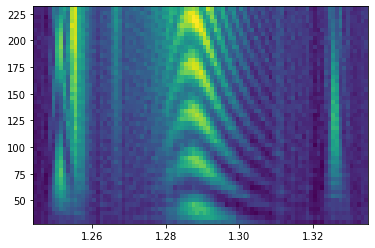

In [12]:
plt.pcolormesh(experimental_freqs, experimental_time, experimental_fids, shading='auto')

In [13]:
# rescale data to 0-1 scale for fidelity
# normalized_experimental_fids = ((experimental_fids - np.amin(experimental_fids)) / np.amax(experimental_fids))
normalized_experimental_fids = ((experimental_fids - np.amin(experimental_fids)))
normalized_experimental_fids /= np.amax(normalized_experimental_fids)

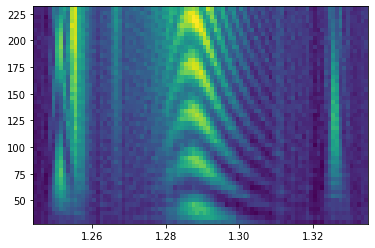

In [14]:
plt.pcolormesh(experimental_freqs, experimental_time, normalized_experimental_fids, shading='auto')
# cool still works

[0.07041023214497229, 0.2307178895754329, 0.4605801290613829, 0.9258326532159632]


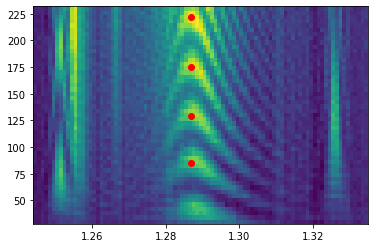

In [15]:
# pick some points to be representative
# we only need to scan over very narrow range around center to get where the chevrons are
freq_points = [1.287, 1.287, 1.287, 1.287]
dur_points = [85, 129, 175, 222]
fid_points = []
for i in range(0, len(dur_points)):
    nearest_freq_index = (np.abs(experimental_freqs - freq_points[i])).argmin()
    nearest_dur_index = (np.abs(experimental_time - dur_points[i])).argmin()
    closest_fidelity = normalized_experimental_fids[nearest_freq_index][nearest_dur_index]
    fid_points.append(closest_fidelity)
plt.pcolormesh(experimental_freqs, experimental_time, normalized_experimental_fids, shading='auto')
plt.scatter(freq_points, dur_points, color='red')
print(fid_points)

# Run Simulations

In [16]:
default_dur = dur_points[0]
default_off = freq_points[0]
_amplitude = None # will be set in function
ramp_coef = 0.5

In [21]:
def vary_offset(off, multiplier=10):
    tlist = np.linspace(0, default_dur, int(default_dur*multiplier))
    tukey.setup(amplitude=_amplitude, drive_frequency= system.first_energy_spacing/3 - off, ramp_coef=ramp_coef, tlist=tlist)
    solution = solver.time_evolve(H_d=system.H0, H_c=system.H1, pertubation_func=tukey.pulse_func, tlist=tlist, starting_state=system.basis_states[0], pbar=False)
    expectation_values = expv.get_all_expectation_values(solution.states, system.basis_states)
    return {
        "fidelity": expectation_values[1][-1],
        "offset": off,
        "frequency":  system.first_energy_spacing/3 - off
    }

def find_center_off():
    # first coarse round
    offs_to_test = np.linspace(0, 3, 67)
    first_results = parfor(vary_offset, offs_to_test)
    _fids_off_sweep = []
    _offs_off_sweep = []
    for result in first_results:
        _fids_off_sweep.append(result["fidelity"])
        _offs_off_sweep.append(result["offset"])
    best_offset = first_results[np.argmax(_fids_off_sweep)]["offset"]
    plt.plot(_offs_off_sweep, _fids_off_sweep)

    # second refined round
    offs_to_test = np.linspace(best_offset-0.3, best_offset+0.3, 123)
    second_results = parfor(vary_offset, offs_to_test)
    _fids_off_sweep = []
    _offs_off_sweep = []
    for result in second_results:
        _fids_off_sweep.append(result["fidelity"])
        _offs_off_sweep.append(result["offset"])
    best_offset = second_results[np.argmax(_fids_off_sweep)]["offset"]
    best_fidelity = second_results[np.argmax(_fids_off_sweep)]["fidelity"]
    plt.plot(_offs_off_sweep, _fids_off_sweep)
    plt.scatter(best_offset, best_fidelity, color="red")
    plt.ylabel("fidelity")
    plt.xlabel("angular frequency offset from 1/3 first energy spacing")
    plt.show()

    return best_offset


In [32]:
def run_sim(amplitude):
    global _amplitude
    _amplitude = amplitude
    # first get the correct center of freq
    center_offset = find_center_off()
    
    # run center offset at every duration in our test list
    results = []
    for dur in dur_points:
        tlist = np.linspace(0, dur, int(dur*5))
        tukey.setup(amplitude, system.first_energy_spacing/3 - center_offset, ramp_coef, tlist)
        solution = solver.time_evolve(system.H0, system.H1, tukey.pulse_func, tlist, system.starting_state)
        fidelity = expv.expectation_value(system.target_state, solution.states[-1])
        results.append({
            "fidelity": fidelity,
            "offset": center_offset,
            "duration": dur,
            "amplitude": amplitude,
            "frequency": (system.first_energy_spacing/3 - center_offset) / (2*np.pi)
        })

    fid_distance = 0
    dur_distance = 0
    freq_distance = 0
    fids = []
    for i in range(0,len(results)):
        result = results[i]
        expected = {
            "duration": dur_points[i],
            "frequency": freq_points[i],
            "fidelity": fid_points[i]
        }
        fids.append(result["fidelity"])
        fid_distance += np.abs(result["fidelity"] - expected["fidelity"])
        dur_distance += np.abs(result["duration"] - expected["duration"])
        freq_distance += np.abs(result["frequency"] - expected["frequency"])

    print("Fidelity Distance: %f" % fid_distance)
    print("Duration Distance: %f" % dur_distance)
    print("Frequency Distance: %f" % freq_distance)

    plt.pcolormesh(experimental_freqs, experimental_time, normalized_experimental_fids, shading='auto')
    plt.scatter(freq_points, dur_points, c=fids, cmap="viridis")
    plt.show()
    
    return {
        "results": results,
        "fids": fids,
        "fid_distance": fid_distance,
        "freq_distance": freq_distance,
        "amplitude": amplitude
    }


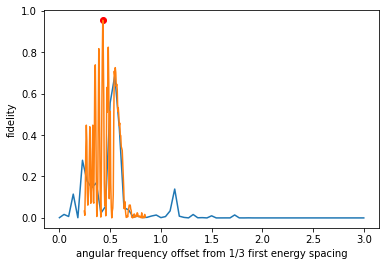

Fidelity Distance: 15.999190
Duration Distance: 0.000000
Frequency Distance: 1.564966


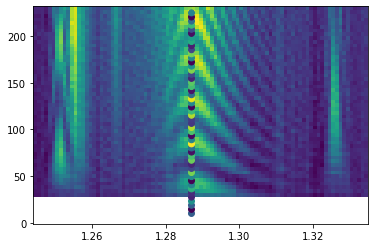

{'results': [{'fidelity': 0.2820493493774198,
   'offset': 0.42742175856929954,
   'duration': 10.0,
   'amplitude': 15.707963267948966,
   'frequency': 1.2557006761441485},
  {'fidelity': 0.000516956790871025,
   'offset': 0.42742175856929954,
   'duration': 14.387755102040817,
   'amplitude': 15.707963267948966,
   'frequency': 1.2557006761441485},
  {'fidelity': 0.2886796936710347,
   'offset': 0.42742175856929954,
   'duration': 18.775510204081634,
   'amplitude': 15.707963267948966,
   'frequency': 1.2557006761441485},
  {'fidelity': 0.48033074382752305,
   'offset': 0.42742175856929954,
   'duration': 23.163265306122447,
   'amplitude': 15.707963267948966,
   'frequency': 1.2557006761441485},
  {'fidelity': 0.09838882589264568,
   'offset': 0.42742175856929954,
   'duration': 27.551020408163264,
   'amplitude': 15.707963267948966,
   'frequency': 1.2557006761441485},
  {'fidelity': 0.12227515994880324,
   'offset': 0.42742175856929954,
   'duration': 31.93877551020408,
   'amplit

In [34]:
dur_points = np.linspace(10, 225, 50)
freq_points = np.repeat(freq_points[0], 50)
fid_points = []
for i in range(0, len(dur_points)):
    nearest_freq_index = (np.abs(experimental_freqs - freq_points[i])).argmin()
    nearest_dur_index = (np.abs(experimental_time - dur_points[i])).argmin()
    closest_fidelity = normalized_experimental_fids[nearest_freq_index][nearest_dur_index]
    fid_points.append(closest_fidelity)
rr = run_sim(1.5*2*np.pi)

  0%|          | 0/10 [00:00<?, ?it/s]

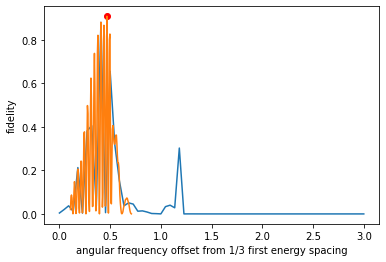

Fidelity Distance: 1.628562
Duration Distance: 0.000000
Frequency Distance: 0.151113


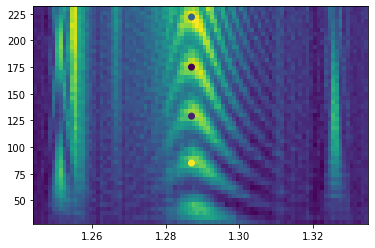

 10%|█         | 1/10 [01:50<16:36, 110.77s/it]

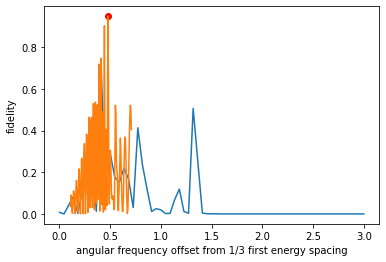

Fidelity Distance: 2.062730
Duration Distance: 0.000000
Frequency Distance: 0.157375


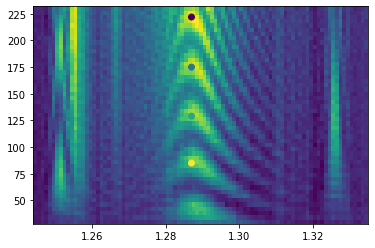

 20%|██        | 2/10 [03:42<14:49, 111.14s/it]

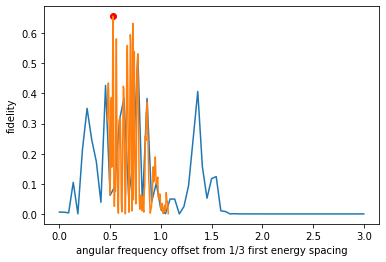

Fidelity Distance: 1.410449
Duration Distance: 0.000000
Frequency Distance: 0.188494


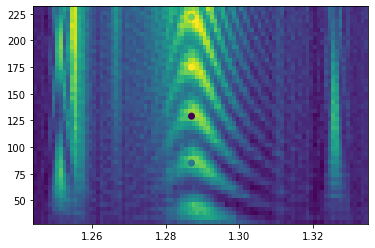

 30%|███       | 3/10 [05:25<12:33, 107.71s/it]

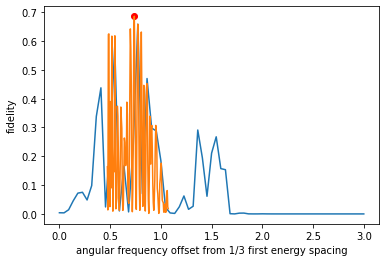

Fidelity Distance: 1.944254
Duration Distance: 0.000000
Frequency Distance: 0.323124


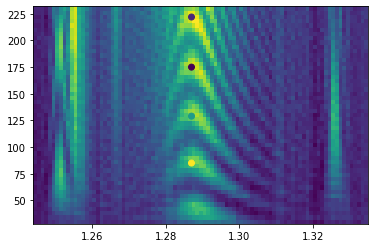

 40%|████      | 4/10 [07:18<10:57, 109.52s/it]

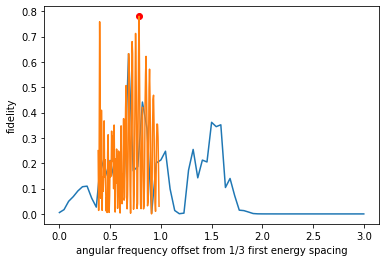

Fidelity Distance: 2.256888
Duration Distance: 0.000000
Frequency Distance: 0.352915


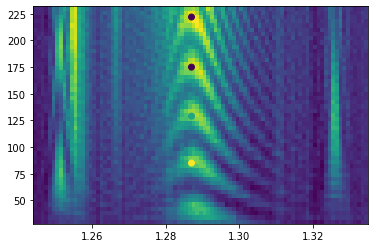

 50%|█████     | 5/10 [09:28<09:44, 116.89s/it]

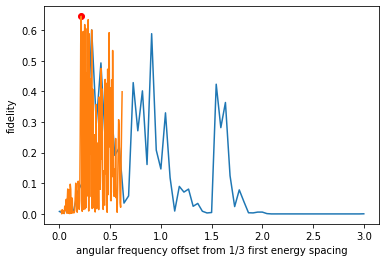

Fidelity Distance: 1.089251
Duration Distance: 0.000000
Frequency Distance: 0.010082


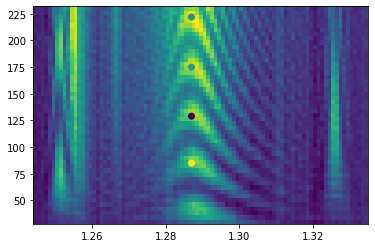

 60%|██████    | 6/10 [11:25<07:48, 117.10s/it]

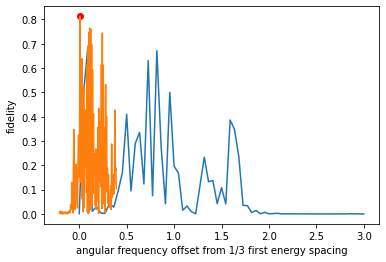

Fidelity Distance: 2.186256
Duration Distance: 0.000000
Frequency Distance: 0.142244


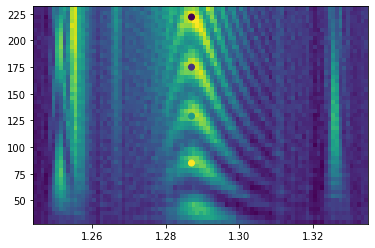

 70%|███████   | 7/10 [13:24<05:52, 117.66s/it]

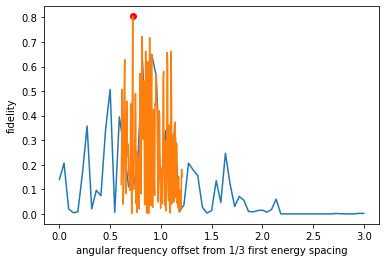

Fidelity Distance: 2.031239
Duration Distance: 0.000000
Frequency Distance: 0.312877


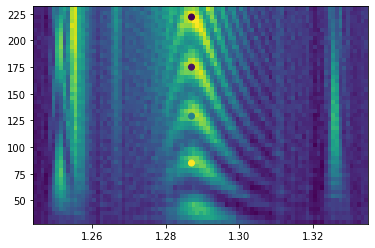

 80%|████████  | 8/10 [15:33<04:02, 121.44s/it]

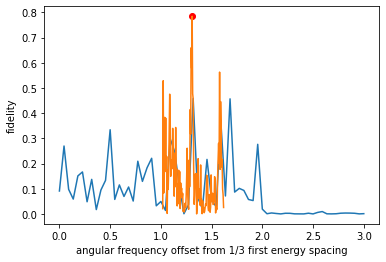

Fidelity Distance: 1.989678
Duration Distance: 0.000000
Frequency Distance: 0.686025


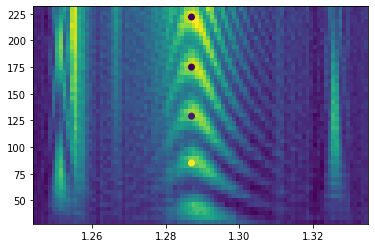

 90%|█████████ | 9/10 [18:10<02:12, 132.58s/it]

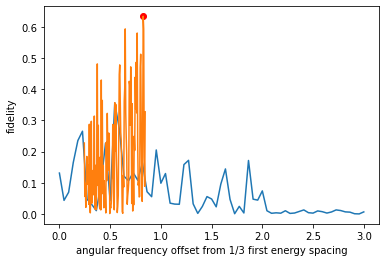

Fidelity Distance: 1.917779
Duration Distance: 0.000000
Frequency Distance: 0.378816


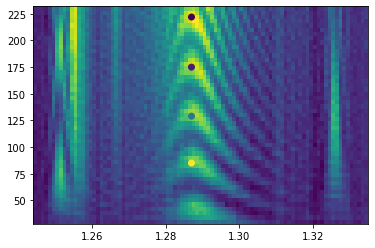

100%|██████████| 10/10 [21:28<00:00, 128.83s/it]


In [15]:
results = []
for amp in tqdm(np.linspace(2.6*2*np.pi, 5*2*np.pi, 10)):
    results.append(run_sim(amp))

In [26]:
(system.first_energy_spacing/3 - 0.5) /(2*np.pi)

1.2441494902595356

## Interpreting Results
It looks like this isnt working too great. I think the problem might be with the center finding. Perhaps if we start from a better starting position and only use this technique to refine I will have better luck! 

amplitude 6.911503837897546


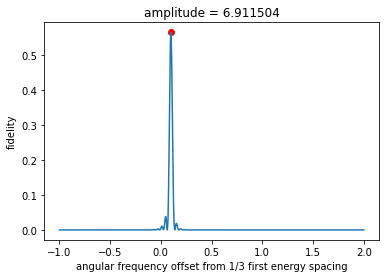

amplitude 7.632222152544616


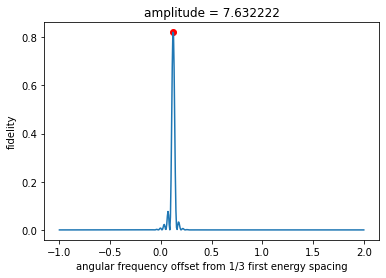

amplitude 8.352940467191686


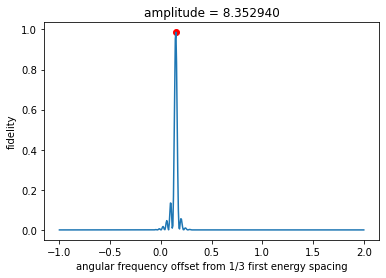

amplitude 9.073658781838756


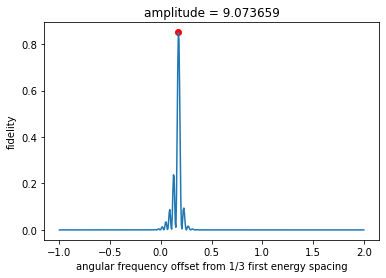

amplitude 9.794377096485826


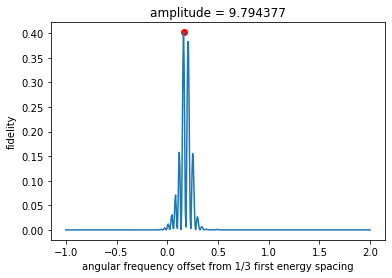

amplitude 10.515095411132897


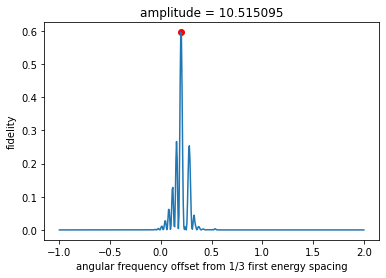

amplitude 11.235813725779966


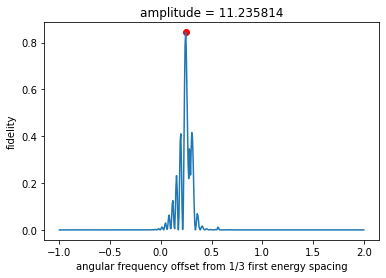

amplitude 11.956532040427037


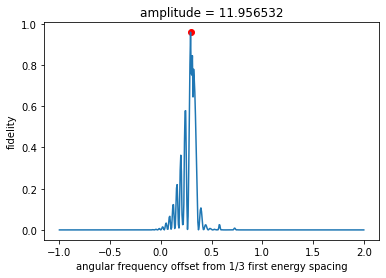

amplitude 12.677250355074108


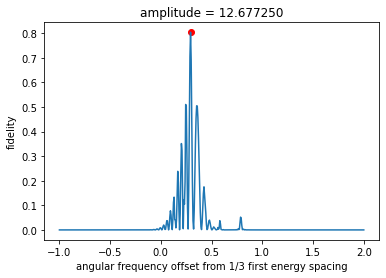

amplitude 13.397968669721177


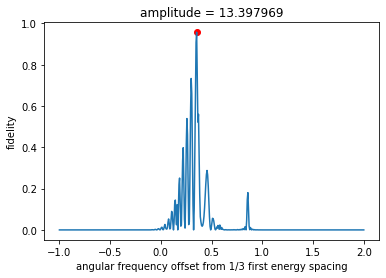

amplitude 14.118686984368246


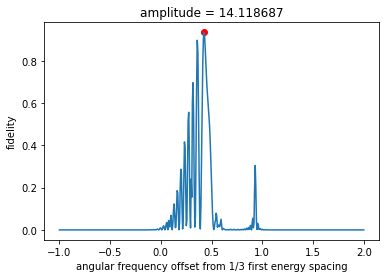

amplitude 14.839405299015318


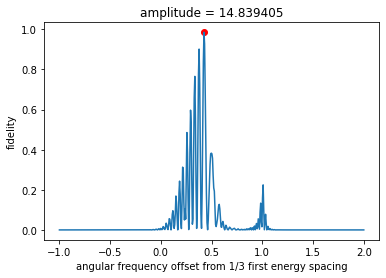

amplitude 15.560123613662387


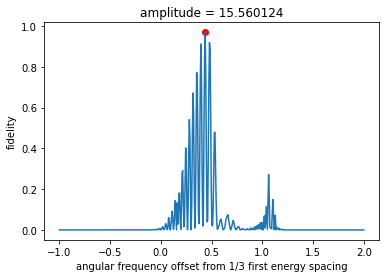

amplitude 16.280841928309457


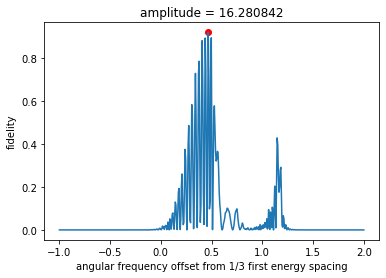

amplitude 17.00156024295653


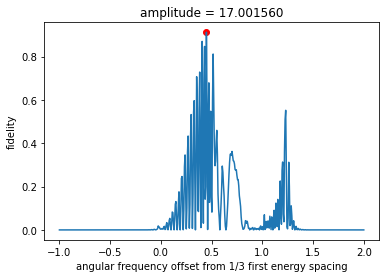

amplitude 17.722278557603598


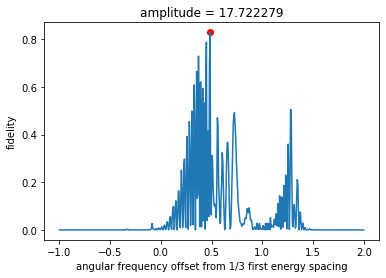

amplitude 18.442996872250667


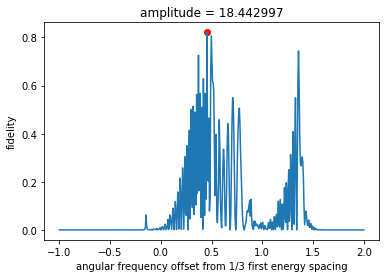

amplitude 19.16371518689774


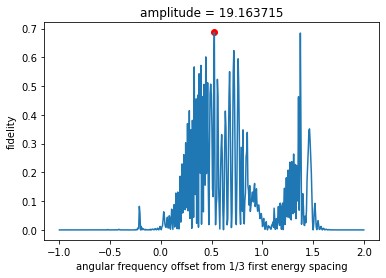

amplitude 19.88443350154481


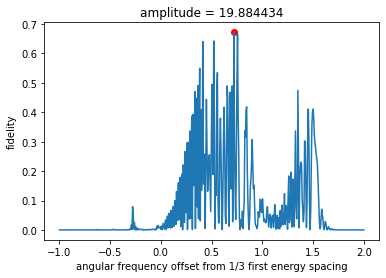

amplitude 20.605151816191878


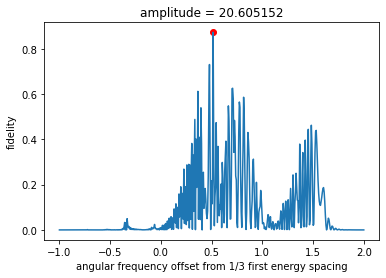

amplitude 21.325870130838947


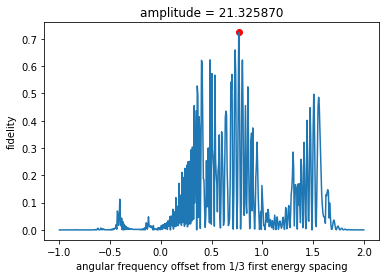

amplitude 22.04658844548602


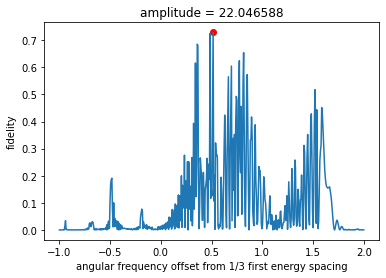

amplitude 22.76730676013309


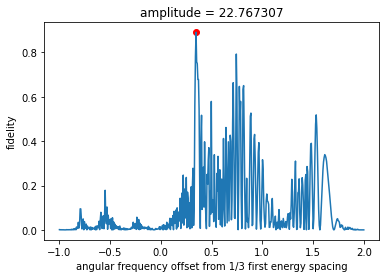

amplitude 23.488025074780158


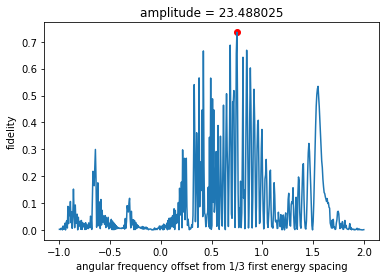

amplitude 24.20874338942723


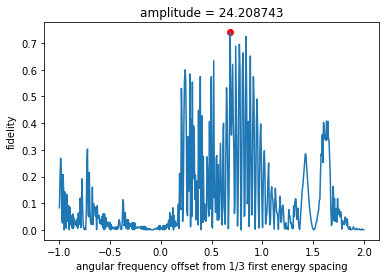

amplitude 24.9294617040743


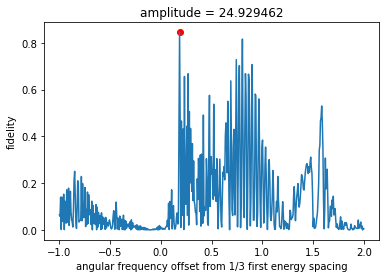

amplitude 25.650180018721368


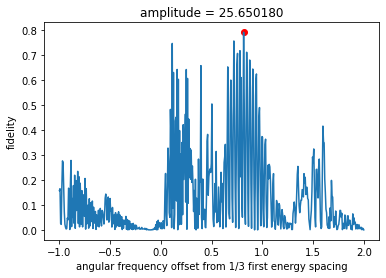

amplitude 26.370898333368437


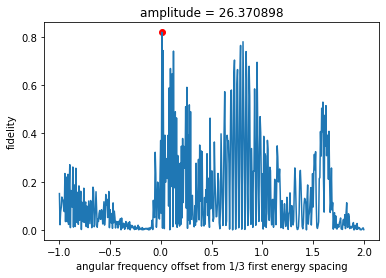

amplitude 27.09161664801551


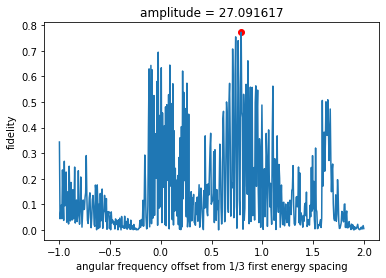

amplitude 27.81233496266258


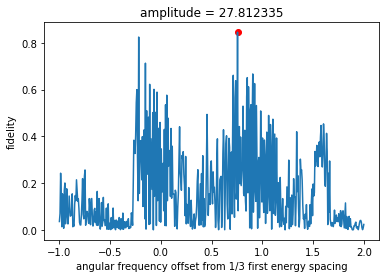

amplitude 28.533053277309648


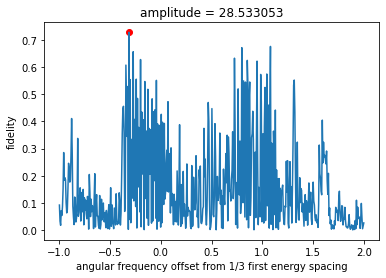

amplitude 29.25377159195672


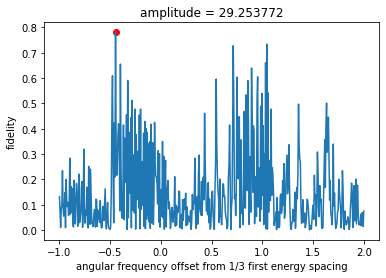

amplitude 29.97448990660379


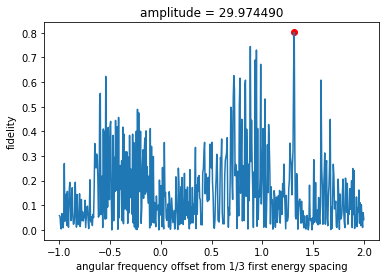

amplitude 30.69520822125086


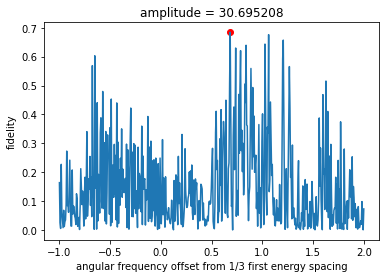

amplitude 31.41592653589793


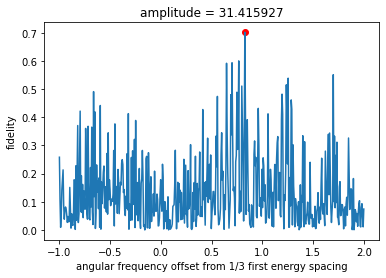

Traceback (most recent call last):
  File "/usr/local/Caskroom/miniforge/base/lib/python3.8/site-packages/qutip/parallel.py", line 127, in parfor
    par_return = list(pool.map(task_func, map_args))
  File "/usr/local/Caskroom/miniforge/base/lib/python3.8/multiprocessing/pool.py", line 364, in map
    return self._map_async(func, iterable, mapstar, chunksize).get()
  File "/usr/local/Caskroom/miniforge/base/lib/python3.8/multiprocessing/pool.py", line 765, in get
    self.wait(timeout)
  File "/usr/local/Caskroom/miniforge/base/lib/python3.8/multiprocessing/pool.py", line 762, in wait
    self._event.wait(timeout)
  File "/usr/local/Caskroom/miniforge/base/lib/python3.8/threading.py", line 558, in wait
    signaled = self._cond.wait(timeout)
  File "/usr/local/Caskroom/miniforge/base/lib/python3.8/threading.py", line 302, in wait
    waiter.acquire()
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/l

In [34]:
results = []
for amp in np.linspace(1.1*2*np.pi, 5*2*np.pi, 35):
    _amplitude = amp
    print("amplitude", _amplitude)

    #  first coarse round
    offs_to_test = np.linspace(-1, 2, 500)
    first_results = parfor(vary_offset, offs_to_test)
    _fids_off_sweep = []
    _offs_off_sweep = []
    for result in first_results:
        _fids_off_sweep.append(result["fidelity"])
        _offs_off_sweep.append(result["offset"])
    best_offset = first_results[np.argmax(_fids_off_sweep)]["offset"]
    best_fidelity = first_results[np.argmax(_fids_off_sweep)]["fidelity"]
    plt.plot(_offs_off_sweep, _fids_off_sweep)
    plt.title("amplitude = %f" % _amplitude)
    plt.ylabel("fidelity")
    plt.xlabel("angular frequency offset from 1/3 first energy spacing")
    plt.scatter(best_offset, best_fidelity, color="red")
    plt.show()

    results.append({
        "amplitude": _amplitude,
        "offs_off_sweep": _offs_off_sweep,
        "fids_off_sweep": _fids_off_sweep,
        "best_offset": best_offset,
        "best_fidelity": best_fidelity
    })
    # plt.show()

# # second refined round
# offs_to_test = np.linspace(best_offset-0.3, best_offset+0.3, 24)
# second_results = parfor(vary_offset, offs_to_test)
# _fids_off_sweep = []
# _offs_off_sweep = []
# for result in second_results:
#     _fids_off_sweep.append(result["fidelity"])
#     _offs_off_sweep.append(result["offset"])
# best_offset = second_results[np.argmax(_fids_off_sweep)]["offset"]
# best_fidelity = second_results[np.argmax(_fids_off_sweep)]["fidelity"]
# plt.plot(_offs_off_sweep, _fids_off_sweep)
# plt.ylabel("fidelity")
# plt.xlabel("angular frequency offset from 1/3 first energy spacing")
# plt.show()

# # third refined round
# offs_to_test = np.linspace(best_offset-0.01, best_offset+0.01, 24)
# second_results = parfor(vary_offset, offs_to_test)
# _fids_off_sweep = []
# _offs_off_sweep = []
# for result in second_results:
#     _fids_off_sweep.append(result["fidelity"])
#     _offs_off_sweep.append(result["offset"])
# best_offset = second_results[np.argmax(_fids_off_sweep)]["offset"]
# best_fidelity = second_results[np.argmax(_fids_off_sweep)]["fidelity"]
# plt.plot(_offs_off_sweep, _fids_off_sweep)
# plt.scatter(best_offset, best_fidelity, color="red")
# plt.ylabel("fidelity")
# plt.xlabel("angular frequency offset from 1/3 first energy spacing")
# plt.show()


In [19]:
# create higher basis size, perhaps we are exciting near edge of our basis causing weirdness
system.setup(system.E_c, system.E_j, _basis_size=40)

amplitude 6.911503837897546


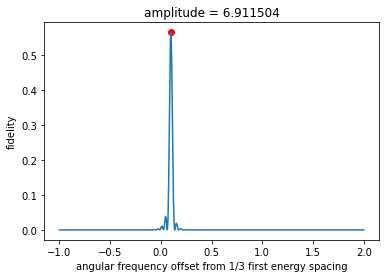

amplitude 7.632222152544616


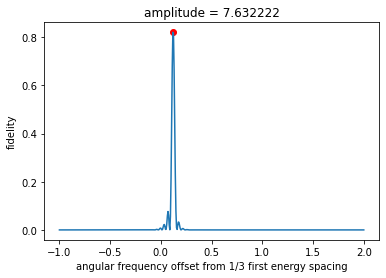

amplitude 8.352940467191686


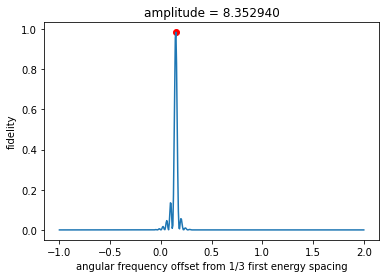

amplitude 9.073658781838756


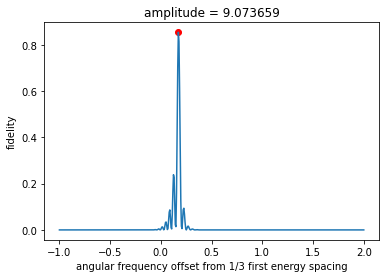

amplitude 9.794377096485826


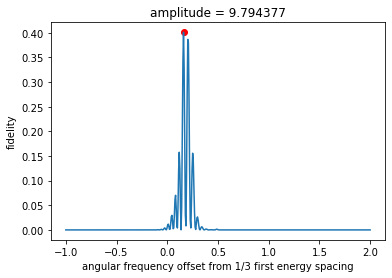

amplitude 10.515095411132897


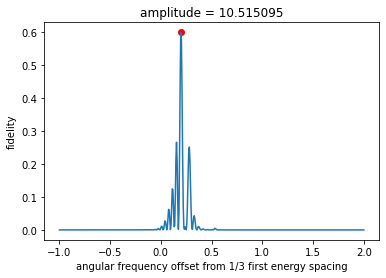

amplitude 11.235813725779966


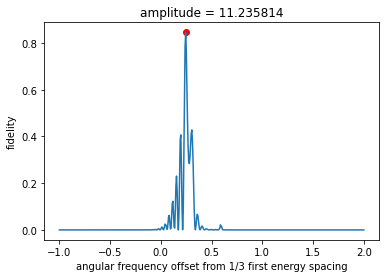

amplitude 11.956532040427037


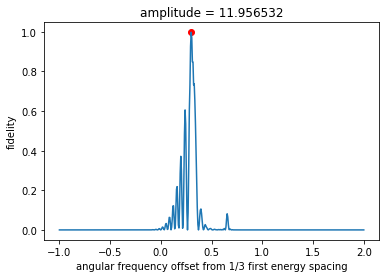

amplitude 12.677250355074108


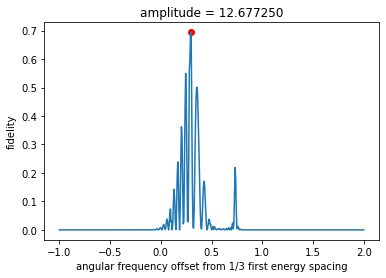

amplitude 13.397968669721177


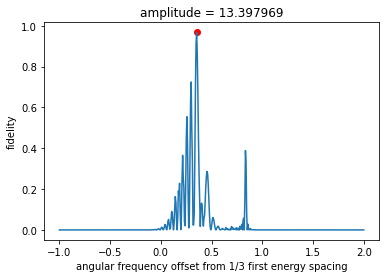

amplitude 14.118686984368246


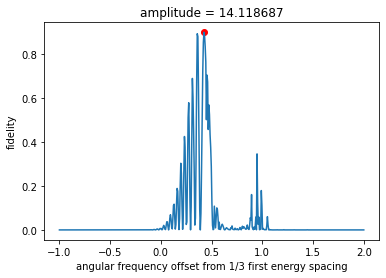

amplitude 14.839405299015318


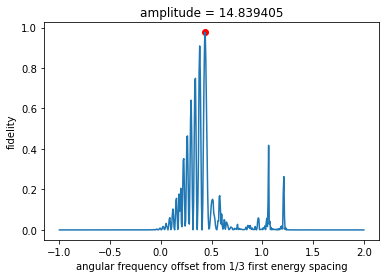

amplitude 15.560123613662387


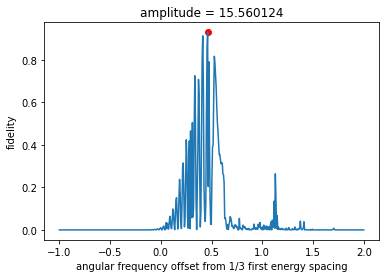

amplitude 16.280841928309457


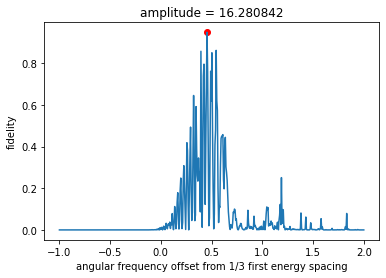

amplitude 17.00156024295653


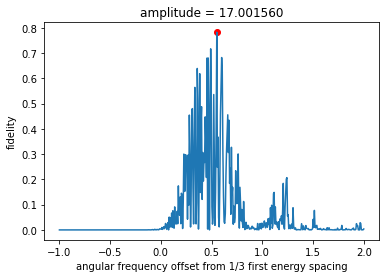

amplitude 17.722278557603598


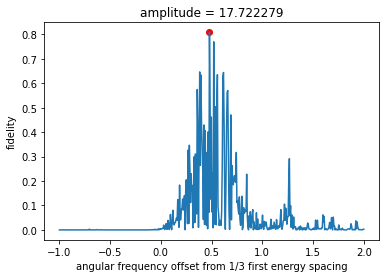

amplitude 18.442996872250667


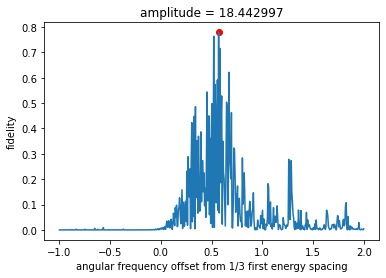

amplitude 19.16371518689774


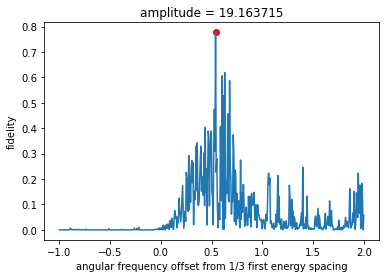

amplitude 19.88443350154481


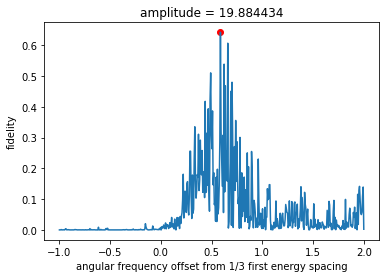

amplitude 20.605151816191878


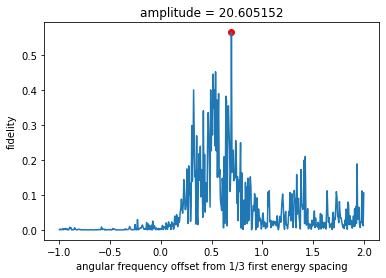

amplitude 21.325870130838947


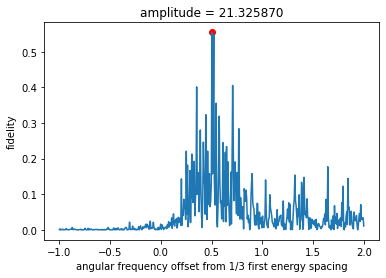

amplitude 22.04658844548602


/usr/local/Caskroom/miniforge/base/lib/python3.8/site-packages/scipy/integrate/_ode.py:1013: UserWarning: zvode: Excess work done on this call. (Perhaps wrong MF.)
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


Exception: ODE integration error: Try to increase the allowed number of substeps by increasing the nsteps parameter in the Options class.

In [22]:
higher_basis_results = []
for amp in np.linspace(1.1*2*np.pi, 5*2*np.pi, 35):
    _amplitude = amp
    print("amplitude", _amplitude)

    #  first coarse round
    offs_to_test = np.linspace(-1, 2, 500)
    first_results = parfor(vary_offset, offs_to_test)
    _fids_off_sweep = []
    _offs_off_sweep = []
    for result in first_results:
        _fids_off_sweep.append(result["fidelity"])
        _offs_off_sweep.append(result["offset"])
    best_offset = first_results[np.argmax(_fids_off_sweep)]["offset"]
    best_fidelity = first_results[np.argmax(_fids_off_sweep)]["fidelity"]
    plt.plot(_offs_off_sweep, _fids_off_sweep)
    plt.title("amplitude = %f" % _amplitude)
    plt.ylabel("fidelity")
    plt.xlabel("angular frequency offset from 1/3 first energy spacing")
    plt.scatter(best_offset, best_fidelity, color="red")
    plt.show()

    higher_basis_results.append({
        "amplitude": _amplitude,
        "offs_off_sweep": _offs_off_sweep,
        "fids_off_sweep": _fids_off_sweep,
        "best_offset": best_offset,
        "best_fidelity": best_fidelity
    })
    # plt.show()


In [37]:
higher_basis_results[5]

{'amplitude': 10.515095411132897,
 'offs_off_sweep': [-1.0,
  -0.9939879759519038,
  -0.9879759519038076,
  -0.9819639278557114,
  -0.9759519038076152,
  -0.969939879759519,
  -0.9639278557114228,
  -0.9579158316633266,
  -0.9519038076152304,
  -0.9458917835671343,
  -0.9398797595190381,
  -0.9338677354709419,
  -0.9278557114228457,
  -0.9218436873747495,
  -0.9158316633266533,
  -0.9098196392785571,
  -0.9038076152304609,
  -0.8977955911823647,
  -0.8917835671342685,
  -0.8857715430861723,
  -0.8797595190380761,
  -0.87374749498998,
  -0.8677354709418837,
  -0.8617234468937875,
  -0.8557114228456913,
  -0.8496993987975952,
  -0.8436873747494991,
  -0.8376753507014028,
  -0.8316633266533067,
  -0.8256513026052104,
  -0.8196392785571143,
  -0.8136272545090181,
  -0.8076152304609219,
  -0.8016032064128257,
  -0.7955911823647295,
  -0.7895791583166333,
  -0.7835671342685371,
  -0.7775551102204409,
  -0.7715430861723447,
  -0.7655310621242485,
  -0.7595190380761523,
  -0.7535070140280561,


8.120829011562543


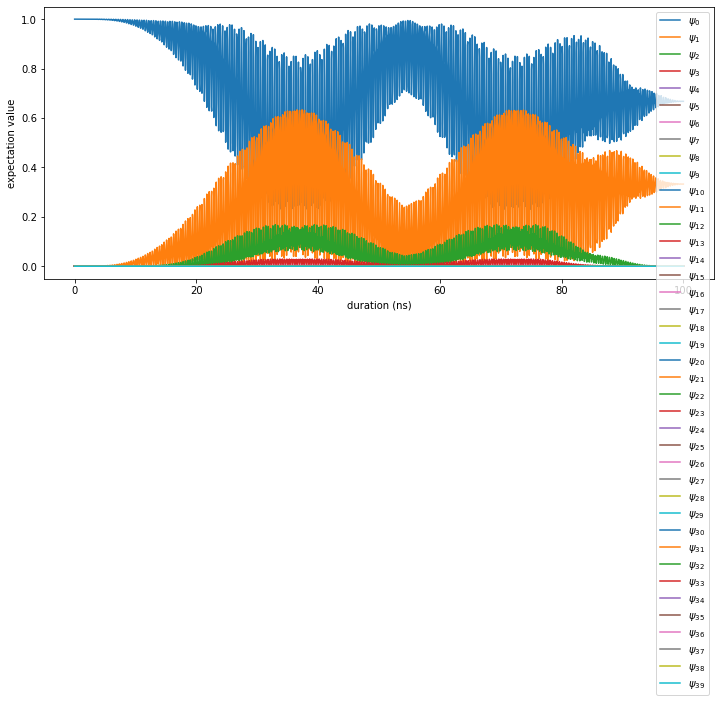

In [38]:
import utils.graph as graph

amp = 10.515095411132897
offset = 0.19639278557114226
freq = system.first_energy_spacing/3 - offset # angular GHz
print(freq)
rc = 0.5
dur = 100
tlist = np.linspace(0, dur, dur*20)
tukey.setup(amp, freq, rc, tlist)

solution = solver.time_evolve(system.H0, system.H1, tukey.pulse_func, tlist, system.basis_states[0], pbar=True)

graph.graph_solution(solution, system)

# Just a bunch of graphs

In [ ]:
offs = np.linspace(1.26*2*np.pi, 1.31*2*np.pi, 30)
durs = np.linspace(5, 225, 30)

def step(dur):
    tlist = np.linspace(0, dur, int(dur*5))
    tukey.setup(amplitude=_amp, drive_frequency= system.first_energy_spacing/3 - _off, ramp_coef=ramp_coef, tlist=tlist)
    solution = solver.time_evolve(H_d=system.H0, H_c=system.H1, pertubation_func=tukey.pulse_func, tlist=tlist, starting_state=system.basis_states[0], pbar=False)
    expectation_values = expv.get_all_expectation_values(solution.states, system.basis_states)
    return {
        "fidelity": expectation_values[1][-1],
        "offset": _off,
        "duration": dur
    }

def sim_graph(amplitude):
    global _amp, _off
    _amp = amplitude
    results = []
    for off in offs:   
        _off = off
        results.append(parfor(step, durs))

    return {
        "amplitude": amplitude,
        "ramp_coef": ramp_coef,
        "results": results
    }

In [ ]:
meta_results = []
for amp in tqdm(np.linspace(1.0*2*np.pi, 3.0*2*np.pi, 10)):
    meta_results.append(sim_graph(amp))

100%|██████████| 10/10 [1:55:39<00:00, 693.96s/it]


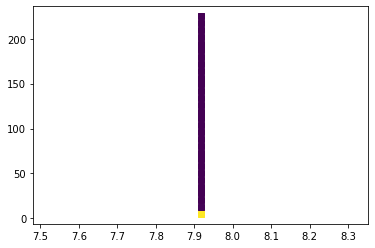

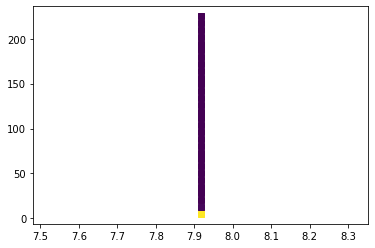

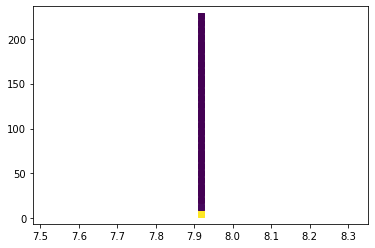

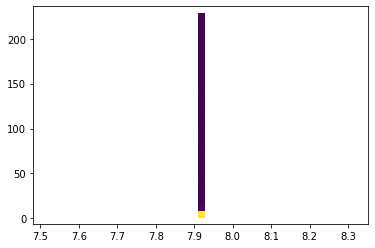

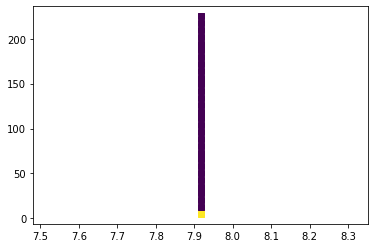

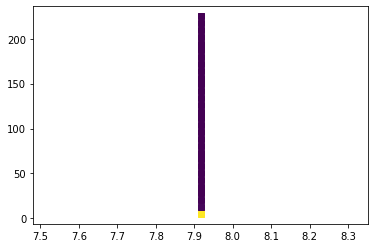

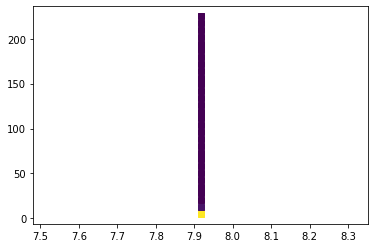

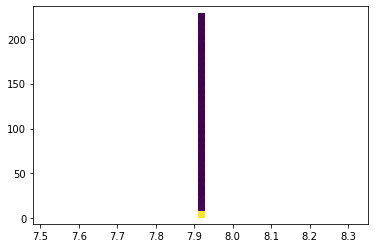

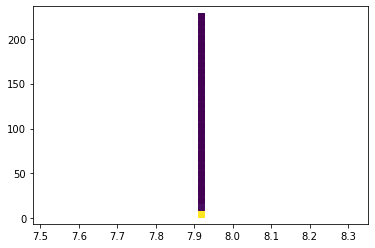

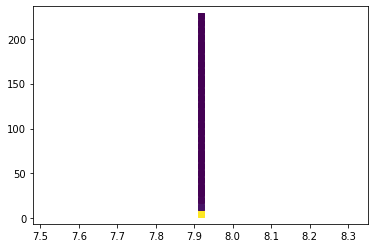

In [ ]:
for result in meta_results:
    offs = []
    durs = []
    fids = []
    for r in result["results"][0]:
        offs.append(r["offset"]) 
        durs.append(r["duration"])
        fids.append(r["fidelity"])

    plt.scatter(offs, durs, c=fids, marker="s")
    plt.show()